In [148]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal,Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage,HumanMessage
from dotenv import load_dotenv
from pydantic import BaseModel,Field
load_dotenv()

True

In [149]:
class strucuted_Schema_For_Tweet_Evolution(BaseModel):
    evolution:Literal['approved','need_improvement']=Field(description='Final Evolution wheather approved or need improvement')
    feedback:str=Field(description='feedback for the tweet')

In [150]:
generator_llm=ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")
evaluator_llm=ChatGoogleGenerativeAI(model="gemini-2.5-pro")
strucutred_evalautor_llm=evaluator_llm.with_structured_output(strucuted_Schema_For_Tweet_Evolution)
optimizer_llm=ChatGoogleGenerativeAI(model="gemini-2.5-flash")

E0000 00:00:1760455094.426574  122842 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1760455094.428960  122842 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1760455094.431953  122842 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [151]:
class TweetState(TypedDict):
    topic:str 
    tweet:str
    evalution:Literal['approved','needs_improvement']
    feedback:str
    iteration:int
    max_iteration:int
    

In [152]:
def generate_tweet(state:TweetState):
    topic=state['topic']
    messages = [
SystemMessage(content="You are funny and clever Twitter/X influencer."),
HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: {topic}.
Rules:
Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
- This is version {state['iteration']+1}
""")
]
    response=generator_llm.invoke(messages).content
    return {
        'tweet':response
    }

In [153]:
def evaulate_tweet(state:TweetState):
    messages = [
SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor,originality, virality, and tweet format."),
HumanMessage(content=f"""
Evaluate the following tweet:
             
Tweet: "{state['tweet']}"
             
Use the criteria below to evaluate the tweet:

1. Originality - Is this fresh, or have you seen it a hundred times before?
2. Humor - Did it genuinely make you smile, laugh, or chuckle?
3. Punchiness - Is it short, sharp, and scroll-stopping?
4. Virality Potential - Would people retweet or share it?
5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 400 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "why |did..." or "what happens when...")
- It exceeds 400 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., "Masterpieces of the auntie-uncle universe" or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"
feedback: One paragraph explaining the strengths and weaknesses

""")
    ]
    response=strucutred_evalautor_llm.invoke(messages)
    return {
        'evalution':response.evolution,"feedback":response.feedback
    }


In [154]:
def optimize_tweet(state:TweetState):
    messages = [
SystemMessage(content= "You punch up tweets for virality and humor based on given feedback."),
HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state["feedback"]}"
Topic: "{state["topic"]}"
Original Tweet:
"{state["tweet"]}"
Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")]
    response=optimizer_llm.invoke(messages).content
    iteration=state['iteration']+1
    return {
         'tweet':response,
         'iteration':iteration
    }

In [155]:
def handle_evolution(state:TweetState)->Literal['optmize','END']:
    if state['evalution']=='approved' or state['iteration']>state['max_iteration']:
        return 'approved'
    return 'needs_improvement'

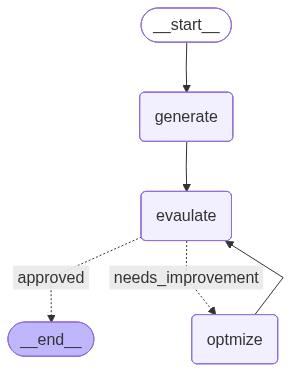

In [156]:
graph=StateGraph(TweetState)

graph.add_node('generate',generate_tweet)
graph.add_node('evaulate',evaulate_tweet)
graph.add_node('optmize',optimize_tweet)


graph.add_edge(START,'generate')
graph.add_edge('generate','evaulate')
graph.add_conditional_edges('evaulate',handle_evolution,{'approved':END,'needs_improvement':'optmize'})
graph.add_edge('optmize','evaulate')

workflow=graph.compile()
workflow



In [157]:
intial_state={
    'topic':'Science',
    'iteration':1,
    'max_iteration':5
}
final_state=workflow.invoke(intial_state)


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 2
Please retry in 12.50402545s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 2
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 12
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>

KeyboardInterrupt: 

In [ ]:
final_state

{'topic': 'Science',
 'tweet': 'Science is great and all, but I also know for a fact that my Wi-Fi signal gets stronger if I stand perfectly still and apologize to it. We all have our own little hypotheses.',
 'evalution': 'approved',
 'feedback': 'This tweet is highly original, offering a humorous and relatable take on personal "hypotheses" that defy scientific logic. The humor is subtle and chuckle-worthy, stemming from the absurdity of apologizing to Wi-Fi. Its conciseness and relatable premise give it strong virality potential, as many can identify with quirky, unscientific beliefs. The format is perfect for Twitter – short, punchy, and under the character limit. It avoids common pitfalls like Q&A or setup-punchline structures, ending on a strong, self-aware note.',
 'iteration': 1,
 'max_iteration': 5}